2025-10-14 10:13:51.468254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760436831.732556      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760436831.819540      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 10:14:08.131073: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Навчання FeedForward (10 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Навчання FeedForward (20 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Навчання Cascade (20 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Навчання Cascade (2x10 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Навчання Elman (15 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Навчання Elman (3x5 нейронів)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


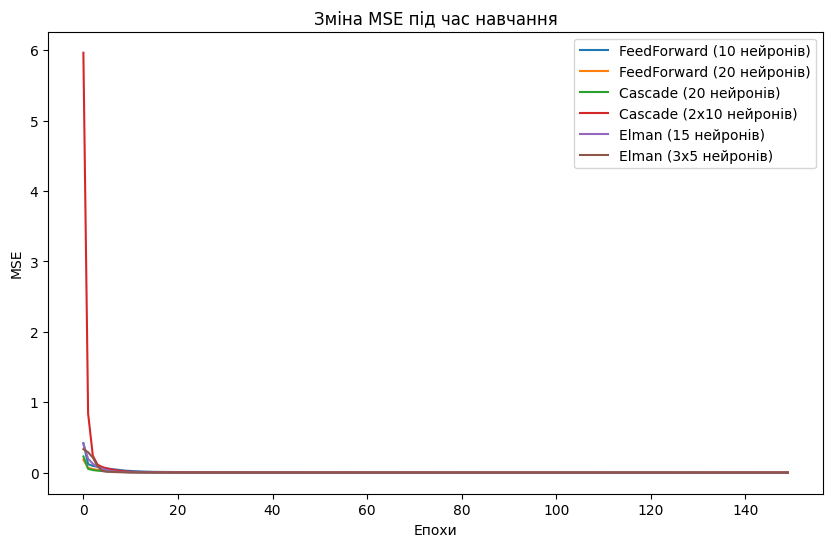

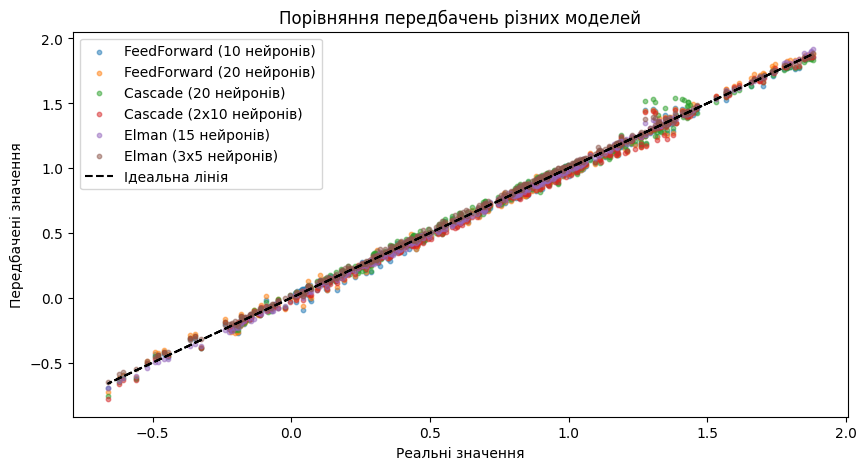


=== РЕЗУЛЬТАТИ ===
FeedForward (10 нейронів): середня відносна помилка = 0.1234, R² = 0.9957
FeedForward (20 нейронів): середня відносна помилка = 0.0887, R² = 0.9959
Cascade (20 нейронів): середня відносна помилка = 0.0918, R² = 0.9952
Cascade (2x10 нейронів): середня відносна помилка = 0.0928, R² = 0.9964
Elman (15 нейронів): середня відносна помилка = 0.0601, R² = 0.9990
Elman (3x5 нейронів): середня відносна помилка = 0.0743, R² = 0.9984


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Add
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras import optimizers

def generate_data(n_samples=2000):
    X = np.random.uniform(0, 10, (n_samples, 2))
    Y = np.sin(X[:, 0] / 2) * np.cos(X[:, 1] / 3) + np.exp(-0.05 * (X[:, 0] - 5)**2)
    return X, Y

def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=150, batch_size=32):
    optimizer = optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_test, Y_test)
    )

    Y_pred = model.predict(X_test)
    error = np.mean(np.abs((Y_test - Y_pred.flatten()) / (Y_test + 1e-8)))
    r2 = r2_score(Y_test, Y_pred)
    return history, error, Y_pred, r2

X, Y = generate_data()
X_train, X_test = X[:1600], X[1600:]
Y_train, Y_test = Y[:1600], Y[1600:]

inputs = Input(shape=(2,))
hidden1 = Dense(20, activation='tanh')(inputs)
output = Dense(1)(hidden1)
output_cascade = Dense(1)(inputs)
final_output = Add()([output, output_cascade])
cascade_model_1 = Model(inputs=inputs, outputs=final_output)

inputs_2 = Input(shape=(2,))
hidden1_2 = Dense(10, activation='tanh')(inputs_2)
hidden2_2 = Dense(10, activation='tanh')(hidden1_2)
output_2 = Dense(1)(hidden2_2)
output_cascade_2 = Dense(1)(inputs_2)
final_output_2 = Add()([output_2, output_cascade_2])
cascade_model_2 = Model(inputs=inputs_2, outputs=final_output_2)

models = {
    "FeedForward (10 нейронів)": Sequential([
        Input(shape=(2,)),
        Dense(10, activation='tanh'),
        Dense(1)
    ]),
    "FeedForward (20 нейронів)": Sequential([
        Input(shape=(2,)),
        Dense(20, activation='tanh'),
        Dense(1)
    ]),
    "Cascade (20 нейронів)": cascade_model_1,
    "Cascade (2x10 нейронів)": cascade_model_2,
    "Elman (15 нейронів)": Sequential([
        Input(shape=(2, 1)),
        SimpleRNN(15, activation='tanh'),
        Dense(1)
    ]),
    
    "Elman (3x5 нейронів)": Sequential([
        Input(shape=(2, 1)),
        SimpleRNN(5, activation='tanh', return_sequences=True),
        SimpleRNN(5, activation='tanh', return_sequences=True),
        SimpleRNN(5, activation='tanh'),
        Dense(1)
    ])
}

errors = {}
predictions = {}
r2_scores = {}

plt.figure(figsize=(10, 6))
for name, model in models.items():
    print(f"Навчання {name}...")
    if "Elman" in name:
        X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train_rnn, Y_train, X_test_rnn, Y_test)
    else:
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train, Y_train, X_test, Y_test)
    errors[name] = error
    predictions[name] = Y_pred
    r2_scores[name] = r2
    plt.plot(history.history['loss'], label=name)

plt.title("Зміна MSE під час навчання")
plt.xlabel("Епохи")
plt.ylabel("MSE")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for name, Y_pred in predictions.items():
    plt.scatter(Y_test, Y_pred, label=name, alpha=0.5, s=10)
plt.plot(Y_test, Y_test, 'k--', label="Ідеальна лінія")
plt.xlabel("Реальні значення")
plt.ylabel("Передбачені значення")
plt.legend()
plt.title("Порівняння передбачень різних моделей")
plt.show()

print("\n=== РЕЗУЛЬТАТИ ===")
for name, error in errors.items():
    print(f"{name}: середня відносна помилка = {error:.4f}, R² = {r2_scores[name]:.4f}")